## 1. Descarga y Preparación del Dataset

In [1]:
import os
import json

## 2. Exploración de Datos


In [2]:
'''
En este paso se eliminan las etiquetas que no son de interés
y se renumeran las etiquetas restantes.
Las etiquetas de interés son:
    2: '0' (carretera)
    3: '1' (río)
'''

import os

source_root = 'data/Etiquetas'
destination_root = 'data/EtiquetasProcesadas'
keep_classes = {'2': '0', '3': '1'}
subdirs = ['train', 'test', 'val']

for subdir in subdirs:
    for root, _, files in os.walk(os.path.join(source_root, subdir)):
        for file in files:
            if file.endswith('.txt'):
                source_path = os.path.join(root, file)
                rel_path = os.path.relpath(source_path, source_root)
                dest_path = os.path.join(destination_root, rel_path)
                os.makedirs(os.path.dirname(dest_path), exist_ok=True)

                with open(source_path, 'r') as src_file:
                    lines = src_file.readlines()

                new_lines = []
                for line in lines:
                    parts = line.strip().split()
                    if parts and parts[0] in keep_classes:
                        parts[0] = keep_classes[parts[0]]
                        new_lines.append(' '.join(parts))

                with open(dest_path, 'w') as dest_file:
                    dest_file.write('\n'.join(new_lines) + '\n' if new_lines else '')


In [3]:
import os
import shutil

# Paths
labels_root = 'data/EtiquetasProcesadas'
images_root = 'data/Procesado/'
output_root = 'data/ImagenesFiltradas'

image_extensions = ['.jpg']
subdirs = ['train', 'test', 'val']

for subdir in subdirs:
    labels_subdir = os.path.join(labels_root, subdir)
    images_subdir = os.path.join(images_root, subdir)
    output_labels_subdir = os.path.join(output_root, subdir, 'labels')
    output_images_subdir = os.path.join(output_root, subdir, 'images')

    os.makedirs(output_labels_subdir, exist_ok=True)
    os.makedirs(output_images_subdir, exist_ok=True)

    for root, _, files in os.walk(labels_subdir):
        for file in files:
            if file.endswith('.txt'):
                label_path = os.path.join(root, file)

                with open(label_path, 'r') as f:
                    lines = [line.strip() for line in f if line.strip()]

                if lines:
                    rel_path = os.path.relpath(label_path, labels_root)
                    rel_base = os.path.splitext(rel_path)[0]
                    new_label_path = os.path.join(output_labels_subdir, os.path.basename(rel_path))
                    shutil.copy(label_path, new_label_path)

                    for ext in image_extensions:
                        image_path = os.path.join(images_subdir, os.path.basename(rel_base) + ext)
                        if os.path.exists(image_path):
                            new_image_path = os.path.join(output_images_subdir, os.path.basename(rel_base) + ext)
                            shutil.copy(image_path, new_image_path)
                            break


In [4]:
from pathlib import Path
FILTERED_IMAGES = Path('data/ImagenesFiltradas/')
if not FILTERED_IMAGES.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {FILTERED_IMAGES}")

                                count
ImagenesFiltradas/train/images    610
ImagenesFiltradas/val/images       74
ImagenesFiltradas/test/images     226


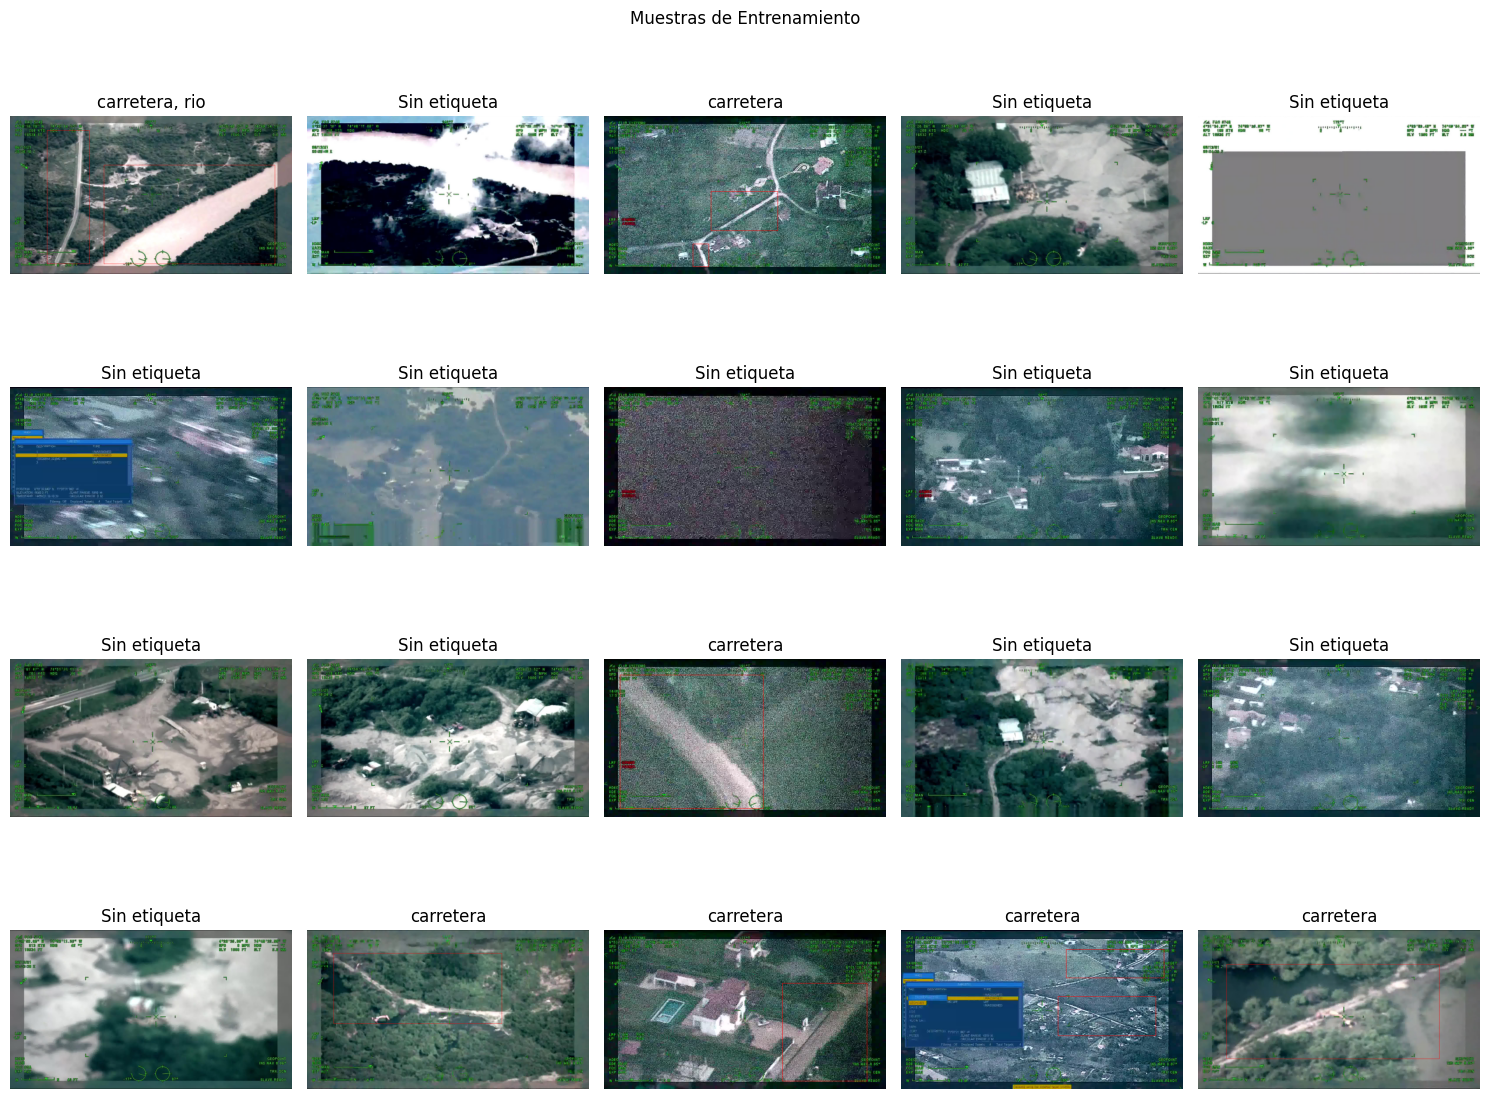

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

DATA_ROOT = Path('data/')
if not DATA_ROOT.exists():
    raise FileNotFoundError(f"Ruta de datos no encontrada: {DATA_ROOT}")

root = DATA_ROOT
train_img = root / 'Imagenes' / 'train'
train_lbl = root / 'EtiquetasProcesadas' / 'train'

# Definir clases
class_names = [
    'carretera', 'rio'
]

# 1. Conteo de imágenes y distribución numérica
counts = {}
for split in ['ImagenesFiltradas/train/images', 'ImagenesFiltradas/val/images', 'ImagenesFiltradas/test/images']:
    path = root / split 
    counts[split] = len(list(path.glob('*.*'))) if path.exists() else 0

# Mostrar tabla de distribución
dist = pd.Series(counts, name='count')
print(dist.to_frame())

# 2. Visualizar muestras con bounding boxes y título de clase
population = list(train_img.glob('*.*'))
if not population:
    raise FileNotFoundError(f"No se encontraron imágenes en {train_img}")

# Tomar hasta 20 muestras
k = min(20, len(population))
sample_images = random.sample(population, k)

n_cols = 5
n_rows = (k + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for ax, img_path in zip(axes.flatten(), sample_images):    
    img = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    w, h = img.size

    lbl_path = train_lbl / f"{img_path.stem}.txt"
    title_labels = set()
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            cls, x_c, y_c, bw, bh = map(float, line.split())
            # Convertir a coordenadas de pixeles
            cx, cy = x_c * w, y_c * h
            bw_pix, bh_pix = bw * w, bh * h
            x1, y1 = cx - bw_pix/2, cy - bh_pix/2
            x2, y2 = cx + bw_pix/2, cy + bh_pix/2
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            title_labels.add(class_names[int(cls)])

    ax.imshow(img)
    ax.set_title(", ".join(sorted(title_labels)) or "Sin etiqueta")
    ax.axis('off')

# Ocultar ejes sobrantes
for ax in axes.flatten()[k:]:
    ax.axis('off')

plt.suptitle('Muestras de Entrenamiento')
plt.tight_layout()
plt.show()

## 3. Preprocesamiento y YAML

En esta sección, se realiza la configuración necesaria para que el modelo YOLO pueda utilizar el conjunto de datos. Esto incluye:

1. **Definición de las clases**: Se especifican las categorías de objetos que el modelo debe detectar. En este caso, las clases corresponden a diferentes tipos de animales, como "Buffalo", "Camel", "Cat", entre otros.

2. **Creación del archivo YAML**: Este archivo es esencial para entrenar modelos YOLO, ya que define la estructura del conjunto de datos. Contiene información como:
   - La ruta base del conjunto de datos.
   - Las particiones de entrenamiento, validación y prueba.
   - El número total de clases (`nc`).
   - Los nombres de las clases (`names`).

El archivo YAML asegura que el modelo pueda interpretar correctamente las imágenes y etiquetas durante el entrenamiento y la evaluación.

In [6]:
yaml_content = f"""
path: {FILTERED_IMAGES.absolute()}
train: train/images
val:   val/images
test:  test/images

nc: {len(class_names)}
names: {class_names}
""".strip()
with open(DATA_ROOT / 'rio-carretera-differentiation.yaml', 'w') as f:
    f.write(yaml_content)

## 4 Arquitectura de YOLO

YOLO (“You Only Look Once”) cambió el paradigma de la detección de objetos al combinar en una sola red la localización y clasificación de instancias, evitando las etapas separadas de propuestas y refinamiento de métodos como R-CNN. Fue introducido por Redmon et al. en 2016 en *“You Only Look Once: Unified, Real-Time Object Detection”* ([ver paper](https://arxiv.org/abs/1506.02640)). Su flujo de datos se compone de:

1. **Backbone**  
   Una CNN profunda que extrae mapas de características a varios niveles de abstracción. En las familias modernas de YOLO suele emplearse CSPDarknet, que reduce la redundancia de gradiente y acelera el entrenamiento.

2. **Neck**  
   Una red de agregación multiescala (por ejemplo PANet o BiFPN) que fusiona los mapas del Backbone para capturar tanto objetos pequeños como grandes de forma eficiente.

3. **Head**  
   La capa final divide el mapa en una cuadrícula y, para cada celda, predice varias cajas delimitadoras, su confianza y la distribución de clases. Aplica Non-Max Suppression para filtrar solapamientos.

> A modo de ejemplo, la siguiente ilustración muestra el esquema general de YOLOv11, con sus tres bloques principales:
>  
> ![Arquitectura YOLOV11](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*L8rMuwurmyBH1ixIqcrMSQ.png)  

### Variantes de YOLOv11

Para distintos balances de velocidad y precisión, YOLOv11 ofrece cinco tamaños preentrenados:

| Variante      | Parámetros aproximados | Uso recomendado                         |
|---------------|------------------------|-----------------------------------------|
| **v11n** (nano)   | ~2.6 M                   | Dispositivos edge, prototipado rápido    |
| **v11s** (small)  | ~9.4 M                   | Móviles, aplicaciones con recursos limitados |
| **v11m** (medium) | ~20.1 M                  | GPU de nivel medio, tareas generales     |
| **v11l** (large)  | ~25.3 M                  | Servidores potentes, máxima precisión     |
| **v11x** (XL)     | ~56.9 M                  | Investigación o despliegue en datacenter  |

En este laboratorio emplearemos **YOLOv11s**, que ofrece un buen compromiso entre velocidad de entrenamiento, latencia de inferencia y calidad de detección.


# 5. Entrenamiento del Modelo

Entrenaremos la variante **small** de YOLOv11 en el conjunto de datos de detección de animales.

Para obtener el modelo preentrenado de las diferentes variantes de YOLOv11, tenemos las siguientes opciones:

- `yolo11n.pt` — **nano**
- `yolo11l.pt` — **small**
- `yolo11m.pt` — **medium**
- `yolo11l.pt` — **large**
- `yolo11x.pt` — **extra large**

In [7]:
%pip install ultralytics --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ultralytics import YOLO
import time

# Cargar modelo base
model = YOLO('yolo11l.pt')

start = time.time()

# Entrenar
results = model.train(
    data=str(root / 'rio-carretera-differentiation.yaml'),
    epochs=50,
    imgsz=640,
    batch=16,
    patience=8,
    name='flir_yolov11l',
    augment=True 
)


end = time.time()
print(f"Execution time: {end-start}")

100%|██████████| 49.0M/49.0M [00:21<00:00, 2.42MB/s]


Ultralytics 8.3.136 🚀 Python-3.9.18 torch-2.7.0 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/rio-carretera-differentiation.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=flir_yolov11l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=8, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/data/ImagenesFiltradas/train/labels.cache... 610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 610/610 [00:00<?, ?it/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1185.0±181.0 MB/s, size: 378.4 KB)



val: Scanning /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/data/ImagenesFiltradas/val/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]

Plotting labels to /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/runs/detect/flir_yolov11l/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/juan/Local/2025-10loc/ISIS4825/proyecto/repositorio/runs/detect/flir_yolov11l
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       2.43       3.17       2.32          7        640: 100%|██████████| 39/39 [29:54<00:00, 46.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.86s/it]

                   all         74        124     0.0121     0.0806    0.00308   0.000815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.508      3.147      2.458          9        640: 100%|██████████| 39/39 [29:28<00:00, 45.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.68s/it]

                   all         74        124    0.00279      0.452    0.00329   0.000855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.524        3.2      2.463          8        640: 100%|██████████| 39/39 [29:20<00:00, 45.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:43<00:00, 14.63s/it]

                   all         74        124          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.494      3.094      2.462         10        640: 100%|██████████| 39/39 [29:27<00:00, 45.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.77s/it]

                   all         74        124     0.0125      0.145    0.00617    0.00182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.468      2.982      2.414         15        640: 100%|██████████| 39/39 [29:10<00:00, 44.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.93s/it]

                   all         74        124      0.018      0.202    0.00862    0.00252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.371      2.851      2.337         11        640: 100%|██████████| 39/39 [29:04<00:00, 44.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.90s/it]

                   all         74        124      0.172      0.161     0.0567      0.017



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.286      2.835      2.275          2        640: 100%|██████████| 39/39 [31:44<00:00, 48.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.89s/it]

                   all         74        124      0.509      0.105     0.0123    0.00398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.284      2.793      2.291         12        640: 100%|██████████| 39/39 [30:48<00:00, 47.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.93s/it]

                   all         74        124      0.144      0.161      0.103     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.275      2.708      2.282          6        640: 100%|██████████| 39/39 [30:11<00:00, 46.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:47<00:00, 15.99s/it]

                   all         74        124      0.153      0.234      0.138     0.0356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.273       2.66       2.27          5        640: 100%|██████████| 39/39 [30:48<00:00, 47.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.02s/it]

                   all         74        124      0.253      0.427      0.232     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.189       2.61        2.2          5        640: 100%|██████████| 39/39 [29:17<00:00, 45.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.54s/it]

                   all         74        124      0.585      0.218      0.194     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.148      2.523      2.172          6        640: 100%|██████████| 39/39 [29:09<00:00, 44.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]

                   all         74        124      0.251      0.394      0.191     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.169      2.509       2.18          5        640: 100%|██████████| 39/39 [29:18<00:00, 45.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.98s/it]

                   all         74        124      0.272      0.339      0.266     0.0947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.113      2.458      2.117         10        640: 100%|██████████| 39/39 [29:35<00:00, 45.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.19s/it]

                   all         74        124      0.319      0.444       0.25     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.098      2.397      2.116          9        640: 100%|██████████| 39/39 [29:22<00:00, 45.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.57s/it]

                   all         74        124      0.366      0.508      0.302      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.093      2.399      2.114          4        640: 100%|██████████| 39/39 [29:13<00:00, 44.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.57s/it]

                   all         74        124      0.542      0.423       0.43       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.071      2.377      2.092         11        640: 100%|██████████| 39/39 [29:19<00:00, 45.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.61s/it]

                   all         74        124       0.29      0.363      0.258     0.0877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.061      2.364      2.077          4        640: 100%|██████████| 39/39 [29:27<00:00, 45.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.69s/it]

                   all         74        124      0.438      0.508      0.416      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G       2.06      2.312      2.039          8        640: 100%|██████████| 39/39 [29:24<00:00, 45.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.55s/it]

                   all         74        124       0.38      0.422      0.269     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.995      2.256       2.03          9        640: 100%|██████████| 39/39 [29:19<00:00, 45.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]

                   all         74        124      0.435      0.317      0.321      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.007      2.242      2.031         11        640: 100%|██████████| 39/39 [29:28<00:00, 45.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

                   all         74        124      0.447      0.274       0.34      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.963      2.145      1.985         10        640: 100%|██████████| 39/39 [29:45<00:00, 45.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.60s/it]

                   all         74        124      0.524      0.427       0.44      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.942      2.141      1.974          8        640: 100%|██████████| 39/39 [29:10<00:00, 44.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.83s/it]

                   all         74        124      0.523        0.5      0.465      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.962      2.165      1.983          4        640: 100%|██████████| 39/39 [29:10<00:00, 44.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.75s/it]

                   all         74        124      0.603      0.338      0.424      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.939      2.123      1.957         17        640: 100%|██████████| 39/39 [29:15<00:00, 45.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]

                   all         74        124      0.465      0.565      0.462      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.895      2.073      1.938         13        640: 100%|██████████| 39/39 [29:52<00:00, 45.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.53s/it]

                   all         74        124      0.434      0.548      0.442       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.892      2.008       1.95         10        640: 100%|██████████| 39/39 [29:24<00:00, 45.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.57s/it]

                   all         74        124      0.446      0.468      0.432      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.881      2.016      1.931          8        640: 100%|██████████| 39/39 [29:11<00:00, 44.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.83s/it]

                   all         74        124      0.651      0.524      0.538      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.872      2.019      1.916          8        640: 100%|██████████| 39/39 [29:11<00:00, 44.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.91s/it]

                   all         74        124      0.655      0.426      0.461      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.894      1.971      1.918          8        640: 100%|██████████| 39/39 [29:14<00:00, 44.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.69s/it]

                   all         74        124      0.844      0.556       0.61      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.825      1.909      1.885          8        640: 100%|██████████| 39/39 [29:22<00:00, 45.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.52s/it]

                   all         74        124      0.502      0.411      0.396      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.882      1.951      1.917         12        640: 100%|██████████| 39/39 [29:07<00:00, 44.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.53s/it]

                   all         74        124       0.61      0.584      0.528      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.847      1.921      1.885          7        640: 100%|██████████| 39/39 [29:10<00:00, 44.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.81s/it]

                   all         74        124      0.635        0.5      0.547      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.789      1.895      1.874          8        640: 100%|██████████| 39/39 [29:13<00:00, 44.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.72s/it]

                   all         74        124      0.543      0.508      0.491      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.816      1.817      1.855         10        640: 100%|██████████| 39/39 [29:20<00:00, 45.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.64s/it]

                   all         74        124      0.591      0.541      0.562      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.82      1.847      1.855          9        640: 100%|██████████| 39/39 [29:12<00:00, 44.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.50s/it]

                   all         74        124      0.645      0.548      0.542      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.786      1.764       1.82          7        640: 100%|██████████| 39/39 [29:04<00:00, 44.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.56s/it]

                   all         74        124      0.666      0.621      0.579      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G       1.75      1.768      1.813          6        640: 100%|██████████| 39/39 [29:10<00:00, 44.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.50s/it]

                   all         74        124      0.778       0.62      0.631      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.777      1.746      1.827          6        640: 100%|██████████| 39/39 [29:09<00:00, 44.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:42<00:00, 14.01s/it]

                   all         74        124      0.746      0.568      0.612      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.736      1.711       1.78          7        640: 100%|██████████| 39/39 [29:11<00:00, 44.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.68s/it]

                   all         74        124      0.652      0.565      0.574      0.255


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.803      1.756      1.884          4        640: 100%|██████████| 39/39 [28:16<00:00, 43.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.66s/it]

                   all         74        124      0.808      0.611      0.652      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       1.76      1.638      1.869          3        640: 100%|██████████| 39/39 [28:17<00:00, 43.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.84s/it]

                   all         74        124       0.74      0.554       0.58       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.702      1.604      1.823          2        640: 100%|██████████| 39/39 [28:11<00:00, 43.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:41<00:00, 13.90s/it]

                   all         74        124      0.644      0.524      0.539      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.682      1.545      1.795          4        640: 100%|██████████| 39/39 [28:12<00:00, 43.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]

                   all         74        124      0.653      0.602      0.596      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.654      1.511      1.773         26        640:  15%|█▌        | 6/39 [04:28<24:38, 44.80s/it]